<a href="https://colab.research.google.com/github/songseunghei/DeepLearning/blob/main/naver_movie_review_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
!pip install konlpy
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 42.0 MB/s eta 0:00:00


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7e1409cdeb90>)

In [3]:
#훈련데이터와 테스트 데이터 저장
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
#train_data 존재하는 리뷰개수 확인
print('훈련용 리뷰 개수:', len(train_data))

훈련용 리뷰 개수: 150000


In [5]:
#샘플 출력
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
print('테스트용 리뷰개수:', len(test_data))

테스트용 리뷰개수: 50000


In [8]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [9]:
#데이터 정제
#document열과 label열의 중복을 제외한 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [13]:
#document열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print( '총 샘플 수: ', len(train_data))

총 샘플 수:  146183


<Axes: >

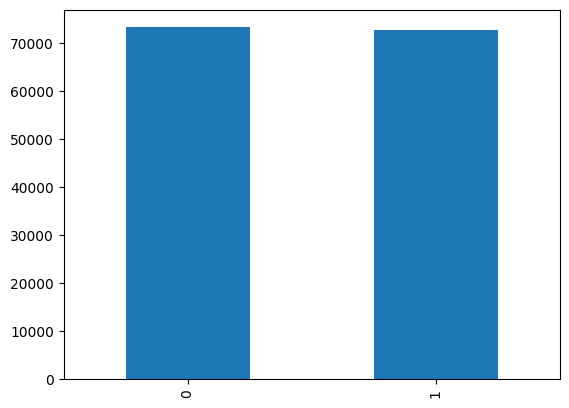

In [14]:
#긍부정 레이블 값의 분포
train_data['label'].value_counts().plot(kind='bar')

In [15]:
#정확한 긍부정 값의 개수 확인
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [16]:
#null값 있는 샘플 확인
print(train_data.isnull().values.any())

True


In [17]:
#null값있는 샘플 어느열에 위치하는지 확인
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [18]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [19]:
#null값 샘플 제거
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


In [20]:
#데이터 전처리(한글만 남기고 특수문자 제거)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎ ㅏ ㅡ ㅣ 가-힣]","")
train_data[:5]

<ipython-input-20-e2755322bdcd>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎ ㅏ ㅡ ㅣ 가-힣]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [23]:
#빈값을 가진 행있다면 null값으로 변경, Null값 존재 여부 확인
train_data['document'] = train_data['document'].str.replace('^ +',"")
train_data['document'].replace('',np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    802
label         0
dtype: int64


<ipython-input-23-4e0e6214e1a2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +',"")


In [44]:
#null 샘플 데이터 제거
train_data = train_data.dropna(how='any')
print(len(train_data))

145380


In [46]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎ ㅏㅡ ㅣ 가-힣]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
print('전처리 후 테스트용 샘플 개수:', len(test_data))

전처리 후 테스트용 샘플 개수: 48370


<ipython-input-46-b22614320920>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎ ㅏㅡ ㅣ 가-힣]","")
<ipython-input-46-b22614320920>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


In [47]:
X_train=[]
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if
                                not word in stopwords]
  X_train.append(stopwords_removed_sentence)
print(X_train[:3])

100%|██████████| 145380/145380 [12:49<00:00, 188.96it/s]

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [50]:
#테스트 데이터 토큰화 진행
X_test = []
for sentence in tqdm(test_data['document']):
  sentence = str(sentence) if not pd.isnull(sentence) else ''
  tokenized_sentence = okt.morphs(sentence, stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence
                                if not word in stopwords]
  X_test.append(stopwords_removed_sentence)
print(X_test[:3])

100%|██████████| 48370/48370 [04:54<00:00, 164.35it/s]

[['굳다', 'ㅋ'], [], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다']]


In [51]:
#정수 인코딩 수행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '것': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '이렇다': 42, '말': 43, '고': 44, '아깝다': 45, '더': 46, '배우': 47, '때': 48, 'ㅋㅋ': 49, '아': 50, '감독': 51, '거': 52, '그냥': 53, '재미있다': 54, '요': 55, '재미': 56, '시간': 57, '내용': 58, '뭐': 59, '까지': 60, '중': 61, '주다': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '쓰레기': 67, '수': 68, '네': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '이건': 83, '정도': 84, '저': 85, '완전': 86, 'ㅋ': 87, '오다': 88, '많다': 89, 'ㅋㅋㅋ': 90, '처음': 91, '장면': 92, '액션': 93, '주인공': 94, '이렇게': 95, '안되다': 96, '걸': 97, '차다': 98, '나다': 99, '개': 100, '하': 101, '최악': 1

In [52]:
#빈도수 낮은 단어 자연어처리에서 배제
threshold = 3
#단어의 수
total_cnt = len(tokenizer.word_index)
#등장 빈도수가 threshold보다 적은 개수 카운트
rare_cnt = 0
#전체 단어 빈도수 총합
total_freq = 0
#등장 빈도수가 적은 단어의 등장 빈도수의 총합
rare_freq=0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value
print('단어 집합의 크기', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold -1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:' , (rare_freq/total_freq)*100)

단어 집합의 크기 43563
등장 빈도가 2번 이하인 희귀 단어의 수: 24199
단어 집합에서 희귀 단어의 비율: 55.54943415283612
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8679665727673604


In [53]:
#등장 빈도 2회 이하 단어 정수 인코딩 과정에서 배제
vocab_size = total_cnt - rare_cnt+1
print('단어 집합의 크기:', vocab_size)


단어 집합의 크기: 19365


In [54]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])

[[50, 451, 16, 259, 657], [928, 454, 41, 600, 1, 213, 1443, 24, 956, 673, 19], [382, 2435, 2278, 5657, 2, 221, 9]]


In [55]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [56]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [57]:
#빈 샘플들 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145139
145139


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰 최대 길이: 69
리뷰 평균 길이: 10.774388689463205


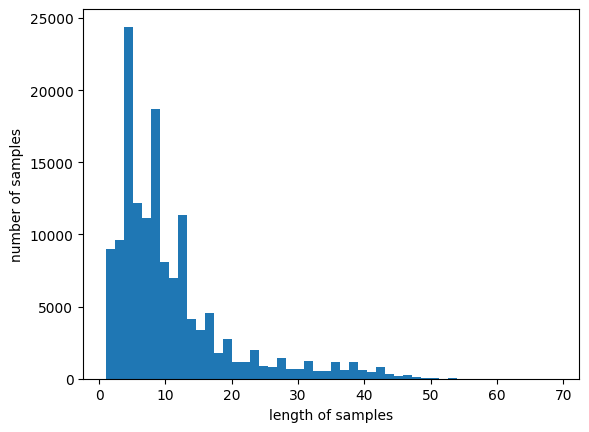

In [58]:
#서로 다른 길이의 샘플 길이 맞춰주는 패딩작업 진행
print('리뷰 최대 길이:', max(len(review) for review in X_train))
print('리뷰 평균 길이:',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [59]:
#max_len이하인 샘플의 비율 %확인
def below_threshold_len(max_len, nested_list):
  count =0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count = count + 1
  print('전체 샘플 중 %s 이하인 샘플의 비율: %s'%(max_len, (count/ len(nested_list))*100))
max_len=30
below_threshold_len(max_len, X_train)

전체 샘플 중 30 이하인 샘플의 비율: 94.34886557024646


In [60]:
#모든 리뷰 샘플 길이 30으로 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [62]:
#LSTM으로 네이버 영화 리뷰 감성 분류

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks = [es, mc], batch_size=64, validation_split=0.2)

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test,y_test)[1]))

Epoch 1/15
1815/1815 [==============================] - ETA: 0s - loss: 0.4096 - acc: 0.8120
Epoch 1: val_acc improved from -inf to 0.83574, saving model to best_model.h5
1815/1815 [==============================] - 33s 17ms/step - loss: 0.4096 - acc: 0.8120 - val_loss: 0.3716 - val_acc: 0.8357
Epoch 2/15
  17/1815 [..............................] - ETA: 11s - loss: 0.3448 - acc: 0.8557

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1815/1815 [==============================] - ETA: 0s - loss: 0.3471 - acc: 0.8490
Epoch 2: val_acc improved from 0.83574 to 0.84429, saving model to best_model.h5
1815/1815 [==============================] - 16s 9ms/step - loss: 0.3471 - acc: 0.8490 - val_loss: 0.3563 - val_acc: 0.8443
Epoch 3/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3206 - acc: 0.8631
Epoch 3: val_acc improved from 0.84429 to 0.85025, saving model to best_model.h5
1815/1815 [==============================] - 13s 7ms/step - loss: 0.3206 - acc: 0.8631 - val_loss: 0.3425 - val_acc: 0.8502
Epoch 4/15
1815/1815 [==============================] - ETA: 0s - loss: 0.2976 - acc: 0.8754
Epoch 4: val_acc improved from 0.85025 to 0.85269, saving model to best_model.h5
1815/1815 [==============================] - 13s 7ms/step - loss: 0.2976 - acc: 0.8754 - val_loss: 0.3443 - val_acc: 0.8527
Epoch 5/15
1815/1815 [==============================] - ETA: 0s - loss: 0.2783 - acc: 0.8865
Epoch 5: val_acc improve

In [65]:
#tokenizer 객체를 파일에 저장하고 다시 로드하는 과정
#나중에 모델 다시 사용시 동일한 토큰화를 로드하여 일관된 데이터 전처리 보장할 수 있음

with open('tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer, handle)
with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

In [67]:
#리뷰 예측
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎ ㅏ ㅊ ㅣ 가-힣]', '', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True)
  new_sentence = [word for word in new_sentence if not word in stopwords]

  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen=max_len)
  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score*100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1- score)*100))

In [71]:
sentiment_predict('이걸 영화라고 만듬?')

1/1 [==============================] - 0s 91ms/step
84.14% 확률로 부정 리뷰입니다.



In [72]:
sentiment_predict('이별장면에서 눈물 광광ㅠㅠ')

1/1 [==============================] - 0s 46ms/step
71.69% 확률로 긍정 리뷰입니다.

